#### Import Data and Libraries

In [84]:
import swarms
import matplotlib.pyplot as plt
import pandas as pd
import pread as pr
from numpy import linspace, logspace, pi, array, interp, reshape
import numpy as np

plt.style.use('paper')

In [196]:
"""Access times with data.ages in years
          radii with data.radii in meters
          luminosity with data.lumin in watts
First entry is the root directory.
Second entry is the subdirectory.
Third entry is the filename.
"""
Mplt_list = np.array([20, 100, 318, 636, 1590]) # mass values in Baraffe table
    
def data_read(mass):
    data = pr.Pread('data', 'Z002', 'pltlum_M'+str(mass)+'Z002.csv') 
    return data

#### Initial Parameters

In [197]:
AU = 1.496e11
pc = 3.086e16
Msun = 1.989e30
Lsun = 3.828e26
Mmoon = 7.35e22
Mearth = 5.972e24

RHO=1500 
eta = 0.4; Nstr = 6.; Dt = 100.; Dmax = 150000.; R_pl = 6.9911e7
lamb = 1.65e-6

Npts = 500
GPIIWA = 0.2 # GPI inner working angle in arcsec
GPIOWA = 1.2 # Outer working angle

#### Helper Functions

In [198]:
def a_opt(t, s, M_s, M_plt, M_init):
    f_vrel = 4/pi
    Qd = s.computeQd(s.Dc)
    part1 = (M_s/1.989e30)**0.33 * f_vrel**0.55
    part2 = (M_plt/5.972e24)**0.06 * Qd**0.15 * eta
    part3 = t * (M_init/5.972e24) / (RHO * (s.Dc/1000)) 

    return 50 * part1 / part2 * part3**0.24 

In [199]:
def Fstar(Ls, Bnu, Ts, apl):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = Ls * Bnu
    part2 = 4 * sig * Ts ** 4 * apl ** 2
    return part1 / part2

In [200]:
def contrast_scat(A, g, Q, a_pl):
    return (A*g*Q) / (pi*a_pl**2)

In [201]:
def lum_to_temp(L, R):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = L / (4 * pi * sig * R**2)
    return (part1)**(1./4.)

#### Compute semi-major axis vs. contrast ratio for scattered swarm light

In [202]:
def swarm_Mplt_contrast(star, t, M0, a_plt, Mplts):
    star_fs_list = []
    star_types = []
    star_contrast_thresh = []
    
    M_s = star['Mass'] * Msun
    L_s = star['Lum'] * Lsun
    T_star = star['Teff']
    d_pl = star['Distance_distance'] * pc
        
    for Mplt in Mplts:
        s2 = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, Mplt,
                                a_plt, R_pl, eta, Nstr, d_pl,
                                rho=RHO, fQ=5, f_vrel=4/pi,
                                correction=True, alpha=1.2)
        s2.updateSwarm(t)

        swarm_contrast = contrast_scat(s2.computeAtot(), 0.32, 0.08, a_plt)
        star_fs_list.append(swarm_contrast)
        
    return star_fs_list, Mplts

In [203]:
def plotting_swarm(fig, ax, star, t, M0, a_plt, Mplts):
    star_fs_list, Mplts = swarm_Mplt_contrast(star, t, M0, a_plt, Mplts)
    
    ax.plot(Mplts/Mearth, star_fs_list, color='b', lw=3, label="Initial mass in irregulars: "+str(M0/Mmoon)+" Lunar Masses")          

In [204]:
TWA = pd.read_csv("../twatargets.csv", index_col=0)
TWA

,TWA,ID,RA_2_A_ICRS_J2017_5_2000,DEC_2_D_ICRS_2017_5_2000,S_Type,Distance_distance,FLUX_I,FLUX_H,Fe_H_Teff,Class,subtype,Mass,Lum,Teff,contrast_thresh,Moving Group,SimbadType,In GPI Sample,Age
0,1,V* TW Hya,11 01 51.8083,-34 42 17.031,K6Ve,60.0860,9.180,7.558,4057,K,6,0.667,0.1200,4057,3.000000e-06,TWA,T Tau-type Star,False,7500000.0
1,2,CD-29 8887,11 09 13.6749,-30 01 40.070,M2Ve,46.0806,8.875,6.927,3704,M,2,0.440,0.0230,3704,2.000000e-06,TWA,T Tau-type Star,False,7500000.0
2,3,Hen 3-600,11 10 27.738,-37 31 51.97,M4Ve+M4Ve,42.0000,9.290,7.041,0,M,4,0.200,0.0055,3100,3.000000e-06,TWA,T Tau-type Star,False,7500000.0
3,4,HD 98800,11 22 05.1800,-24 46 39.757,K5V(e),46.7000,7.386,5.759,4434,K,5,0.700,0.1900,4434,7.000000e-07,TWA,Variable of RS CVn type,False,7500000.0
4,5A,CD-33 7795,11 31 55.1407,-34 36 27.214,M2Ve,49.3786,9.150,6.987,3650,M,2,0.440,0.0230,3650,3.000000e-06,TWA,T Tau-type Star,False,7500000.0
6,6,V* BX Ant,10 18 28.6211,-31 50 02.826,M0Ve,65.6444,9.325,8.180,0,M,0,0.600,0.0720,3800,3.000000e-06,TWA,T Tau-type Star,False,7500000.0
7,7,V* CE Ant,10 42 29.9354,-33 40 16.226,M2Ve,34.0290,9.100,7.125,0,M,2,0.440,0.0230,3400,3.000000e-06,TWA,T Tau-type Star,True,7500000.0
13,13,CD-34 7390,11 21 17.24,-34 46 45.5,M1Ve+M1Ve,38.0000,9.038,NaN,0,M,1,0.490,0.0350,3600,3.000000e-06,TWA,Double or multiple star,False,7500000.0
17,21,HD 298936,10 13 14.6518,-52 30 54.000,K3Ve,53.3504,8.687,7.353,4834,K,3,0.810,0.2600,4834,2.000000e-06,TWA,T Tau-type Star,False,7500000.0


In [205]:
star = TWA.loc[1]
star

TWA                                       2
ID                              CD-29  8887
RA_2_A_ICRS_J2017_5_2000      11 09 13.6749
DEC_2_D_ICRS_2017_5_2000      -30 01 40.070
S_Type                                 M2Ve
Distance_distance                   46.0806
FLUX_I                                8.875
FLUX_H                                6.927
Fe_H_Teff                              3704
Class                                     M
subtype                                   2
Mass                                   0.44
Lum                                   0.023
Teff                                   3704
contrast_thresh                       2e-06
Moving Group                            TWA
SimbadType                  T Tau-type Star
In GPI Sample                         False
Age                                 7.5e+06
Name: 1, dtype: object

#### Compute planet mass vs. contrast ratio for scattered swarm light

In [212]:
def swarm_mass_contrast(t, M_init, star, a_plt):
    # Fix the mass of the planet at 1 M_jup

    star_types = []
    star_cr_list = []
    star_contrast_thresh = []
    for j in range(10):
        cr_list = []
        cr_plt_list = []
        
        star_types.append(star.subtype)
        
        M_s = star['Mass'] * Msun
        L_s = star['Lum'] * Lsun
        T_star = star['Fe_H_Teff']
        d_pl = star['Distance_distance'] * pc
        contrast_thresh = star['contrast_thresh']
        star_contrast_thresh.append(contrast_thresh)
        
        for i in range(len(Mplt_list)):
            plt_data = data_read(str(Mplt_list[i]))
            Mplt = Mplt_list[i]*Mearth

            s = swarms.CollSwarm(M_init, Dt, Dmax, L_s, M_s, Mplt, a_plt, R_pl, eta, Nstr,
                                d_pl, correction=True, alpha=1.2)

            s.updateSwarm(t)

            # Fix the semi-major axis at a_opt
            aopt = a_opt(t, s, M_s, Mplt, M_init)

            B_nu_list = s.computeBmu(array([lamb]), T_star)
            F_star = Fstar(L_s, B_nu_list, T_star, d_pl)/1e-26

            s2 = swarms.CollSwarm(M_init, Dt, Dmax, L_s, M_s, Mplt,
                                    a_plt, R_pl, eta, Nstr, d_pl,
                                    rho=RHO, fQ=5, f_vrel=4/pi,
                                    correction=True, alpha=1.2)

            s2.updateSwarm(t)

            # Planet Emissions
            index = plt_data.find_time_index(t)
            if (index > -1):
                T_plt = lum_to_temp(plt_data.lumin[index], plt_data.radii[index])
                B_nu_plt = s2.computeBmu(array([lamb]), T_plt)
                F_plt = Fstar(plt_data.lumin[index], B_nu_plt, T_plt, d_pl)
                F_plt = F_plt/1e-26
                cr_plt_list.append(F_plt/F_star)
                #print("F_plt: "+"{0:.3e}".format(F_plt[0])+"\t F_star: "+ "{0:.3e}".format(F_star[0]))
            # swarm scattered light
            contrast_swarm = contrast_scat(s2.computeAtot(), 0.32, 0.08, aopt*AU)
            cr_list.append(contrast_swarm)
        star_cr_list.append(cr_plt_list)
    return star_cr_list, star_types, star_contrast_thresh, Mplt_list

In [224]:
from scipy.interpolate import interp1d

def plot_planet_thermal(fig, ax, t, M_init, star, a_plt, Mplts):
    star_cr_list, star_types, star_contrast_thresh, Mplt_list = swarm_mass_contrast(t, M_init, star, a_plt)
    visited_types = []
    color_map = ['r', 'b', 'g', 'y', 'c']
    for i in range(len(star_cr_list)):
        cr_plt_list = array(star_cr_list[i]).flatten()
        cr = interp1d(np.log10(Mplt_list), np.log10(cr_plt_list), kind='linear')
        star_cr = cr(np.log10(Mplts/Mearth))
        ax.plot(Mplts/Mearth, 10**star_cr, color='r', lw=3)          

(1e-09, 1e-05)

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


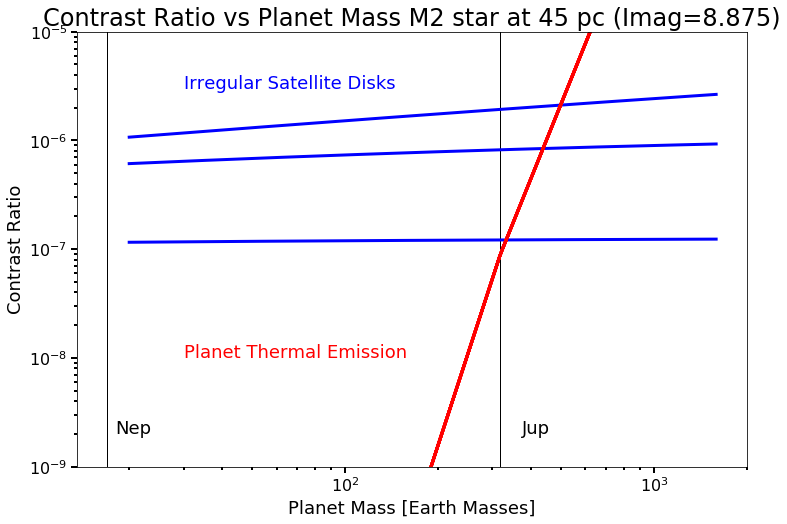

In [228]:
fig, ax = plt.subplots(figsize=(12,8))
    
M0 = 100 * Mmoon
age = 1.e7 # yrs
a_plt = 0.7*star['Distance_distance']*AU # middle of GPI FOV
Mplts = logspace(np.log10(20), np.log10(1590), Npts)*Mearth # ~Neptune to 5 Mj
        
plotting_swarm(fig, ax, star, age, M0, a_plt, Mplts)#, age, color='red', label='TWA Targets (Age={0}Myr)'.format(age/1.e6))
plotting_swarm(fig, ax, star, age, M0/10, a_plt, Mplts)
plotting_swarm(fig, ax, star, age, M0/100, a_plt, Mplts)

plot_planet_thermal(fig, ax, 1.1e7, 100*Mmoon, star, a_plt, Mplts)

contrast_thresh = 1.e-6    
#ax.hlines(contrast_thresh, GPIIWA, GPIOWA, linestyle='--', label="contrast threshold")
ax.vlines(17, 1.e-16, 1, lw=1, color='k')
ax.vlines(318, 1.e-16, 1, lw=1, color='k')

ax.text(18, 2.e-9, "Nep", color='k', fontsize=18)
ax.text(375, 2.e-9, "Jup", color='k', fontsize=18)
ax.text(30, 1.e-8, "Planet Thermal Emission", color='r', fontsize=18)
ax.text(30, 3.e-6, "Irregular Satellite Disks", color='b', fontsize=18)
ax.set_title("Contrast Ratio vs Planet Mass M2 star at 45 pc (Imag=8.875)", fontsize=24)
ax.set_xlabel("Planet Mass [Earth Masses]", fontsize=18)
ax.set_ylabel("Contrast Ratio", fontsize=18)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1e-9, 1e-5])

#### Compute time vs. contrast ratio for scattered swarm light

In [16]:
def swarm_time_contrast(M_init):
    # Fix the mass of the planet at 1 M_jup
    plt_data = data_read("636")
    Mplt = 636*Mearth

    star_types = []
    star_cr_list = []
    star_contrast_thresh = []
    for j in range(10):
        cr_list = []
        cr_plt_list = []
        
        star = Mdwarfs.iloc[j]
        star_types.append(star.subtype)
        
        M_s = star['Mass'] * Msun
        L_s = star['Lum'] * Lsun
        T_star = star['Fe_H_Teff']
        d_pl = star['Distance_distance'] * pc
        contrast_thresh = star['contrast_thresh']
        star_contrast_thresh.append(contrast_thresh)
        
        for i in range(len(time)):
            s = swarms.CollSwarm(M_init, Dt, Dmax, L_s, M_s, Mplt, a_plv[0], R_pl, eta, Nstr,
                                d_pl, correction=True, alpha=1.2)

            s.updateSwarm(time[i])

            # Fix the semi-major axis at a_opt
            aopt = a_opt(time[i], s, M_s, Mplt, M_init)

            B_nu_list = s.computeBmu(array([lamb]), T_star)
            F_star = Fstar(L_s, B_nu_list, T_star, d_pl)/1e-26

            s2 = swarms.CollSwarm(M_init, Dt, Dmax, L_s, M_s, Mplt,
                                    aopt*AU, R_pl, eta, Nstr, d_pl,
                                    rho=RHO, fQ=5, f_vrel=4/pi,
                                    correction=True, alpha=1.2)

            s2.updateSwarm(time[i])

            # Planet Emissions
            index = plt_data.find_time_index(time[i])
            if (index > -1):
                T_plt = lum_to_temp(plt_data.lumin[index], plt_data.radii[index])
                B_nu_plt = s2.computeBmu(array([lamb]), T_plt)
                F_plt = Fstar(plt_data.lumin[index], B_nu_plt, T_plt, d_pl)
                F_plt = F_plt/1e-26
                cr_plt_list.append(F_plt/F_star)
                #print("F_plt: "+"{0:.3e}".format(F_plt[0])+"\t F_star: "+ "{0:.3e}".format(F_star[0]))
            # swarm scattered light
            contrast_swarm = contrast_scat(s2.computeAtot(), 0.32, 0.08, aopt*AU)
            cr_list.append(contrast_swarm)
        star_cr_list.append(cr_list)
    return star_cr_list, star_types, star_contrast_thresh, Mplt

In [17]:
def plotting(M_init):
    star_cr_list, star_types, star_contrast_thresh, Mplt = swarm_time_contrast(M_init)
    visited_types = []
    color_map = ['r', 'b', 'g', 'y', 'c']
    plt.figure(2)
    for i in range(len(star_cr_list)):
        if not (star_types[i] in visited_types):
            plt.loglog(time, star_cr_list[i], color_map[int(star_types[i])], label="M"+str(star_types[i]))
            visited_types.append(star_types[i])
        else:
            plt.loglog(time, star_cr_list[i], color_map[star_types[i]])

    for i in range(len(star_contrast_thresh)):
        plt.hlines(star_contrast_thresh[i], time[0], time[-1], color_map[star_types[i]], linestyles='--')


    #plt.hlines(contrast_thresh, time[0], time[-1], label="contrast threshold")
    plt.title(r"planet mass "+"{0:.2e}".format(Mplt/Mearth)+"$M_{\oplus}$"+
              " and init swarm mass "+"{0:.2e}".format(M_init/Mmoon)+"$M_{moon}$")
    plt.ylabel("contrast ratio")
    plt.xlabel("time [years]")
    plt.ylim(1e-7, 1e-6)
    plt.legend()
    plt.show()

C:\Users\loloynage\Documents\CE-Irregular-Satellites\src\swarms.py:270: RuntimeWarning: divide by zero encountered in true_divide
  b = 1/(exp(h*(c/lamb)/(k_B*T)) - 1)
c:\users\loloynage\this_is_python\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


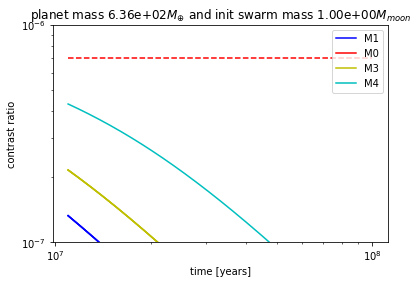

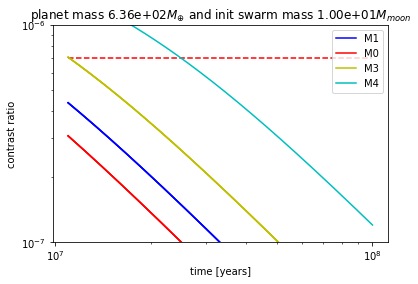

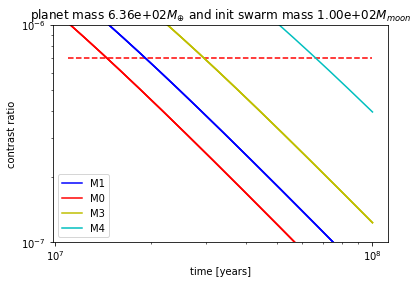

In [18]:
plotting(1*Mmoon)
plotting(10*Mmoon)
plotting(100*Mmoon)